In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from Training import model, utils, dataset, train
import numpy as np
from sklearn import preprocessing
from IPython.display import HTML
from matplotlib import animation
from mpl_toolkits.mplot3d import axes3d

In [2]:
test_model_1 = model.Model500RELUBN()
# load data 1066 data 
data1 = utils.parseGainAndBWCsv('Data/BW_Gain324.csv')
data2 = utils.parseGainAndBWCsv('Data/BW_Gain322.csv')
data3 = utils.parseGainAndBWCsv('Data/BW_Gain2.0.csv')
data4 = utils.parseGainAndBWCsv('Data/BW_Gain324_1.csv')
data1 += data2
data1 += data3
data1 += data4
print(len(data1))
prune_data = utils.get_rid_of_duplicate(data1)
count, prune_data = utils.check_same_x_different_y(prune_data)
data = np.array(prune_data).astype(float)
#data = np.array(data1).astype(float)

3736
([4e-06, 1003.5], [9.299, 37500000000.0]) ([4e-06, 1003.5], [9.293, 37500000000.0])
([4e-06, 1005.5], [9.31, 37400000000.0]) ([4e-06, 1005.5], [9.304, 37500000000.0])
([4e-06, 1007.5], [9.321, 37400000000.0]) ([4e-06, 1007.5], [9.315, 37400000000.0])
([4e-06, 1019.5], [9.386000000000001, 37000000000.0]) ([4e-06, 1019.5], [9.38, 37000000000.0])
([4e-06, 1020.0], [9.388, 36900000000.0]) ([4e-06, 1020.0], [9.383, 37000000000.0])
([4.01e-06, 1019.5], [9.396, 36900000000.0]) ([4.01e-06, 1019.5], [9.391, 36900000000.0])
([4.01e-06, 1020.0], [9.399, 36900000000.0]) ([4.01e-06, 1020.0], [9.394, 36900000000.0])
([4.02e-06, 1019.5], [9.407, 36800000000.0]) ([4.02e-06, 1019.5], [9.402000000000001, 36900000000.0])
([4.02e-06, 1020.0], [9.41, 36800000000.0]) ([4.02e-06, 1020.0], [9.405, 36800000000.0])
([4.02e-06, 1008.5], [9.353, 37100000000.0]) ([4.02e-06, 1008.5], [9.343, 37200000000.0])
([4.02e-06, 1019.5], [9.413, 36800000000.0]) ([4.02e-06, 1019.5], [9.402000000000001, 36900000000.0])
([

In [3]:
print(data.shape)


(1649, 2, 2)


In [4]:
data = data.reshape(data.shape[0],4)
feature = data.T[0]

# ensure norm and denorm work 
norm, data_min, data_max = utils.normalize(feature)
feature_1 = utils.denormalize(norm, data_min, data_max)


min_max = dict()
for i in range(4):
    feature = data.T[i]
    norm_feature, data_min, data_max = utils.normalize(feature)
    data.T[i] = norm_feature
    min_max[i] = [data_min, data_max]
data = data.reshape(data.shape[0],2,2)

In [5]:
data_x = data[:, 1]
data_y = data[: ,0]
data_set = dataset.CircuitSynthesisGainAndBandwidthManually(data_x, data_y)

In [6]:
train_dataset, val_dataset = utils.splitDataset(data_set, 0.8)

In [7]:
dtype = torch.FloatTensor
loss_fn = nn.L1Loss().type(dtype)  # loss can be changed here. This is the first one i tried that gave meaningful results

x = optim.Adam
optimizer1 = x(test_model_1.parameters(), lr=3e-4)#0.06448295999961791)  # TODO haven't experimented with this yet
train_data = DataLoader(train_dataset, batch_size=250)
test_data = DataLoader(val_dataset, batch_size = 50)

In [8]:
total_train = len(train_dataset)
total_test = len(val_dataset)

In [9]:
ta5 = []
ta10 = []
ta20 = []
va5 = []
va10 = []
va20 = []
train_loss = []
for epoch in range(2000):
    #print('Starting epoch %d / %d' % (epoch + 1, num_epochs))

    avg_loss = 0
    tcorrect5 = 0
    tcorrect10 = 0
    tcorrect20 = 0
    vcorrect5 = 0
    vcorrect10 = 0
    vcorrect20 = 0
    test_model_1.eval()
    for t, (x, y) in enumerate(test_data):

        x_var = torch.autograd.Variable(x.type(dtype))
        y_var = torch.autograd.Variable(y.type(dtype).float())

        # make predictions
        scores = test_model_1(x_var)
        

        v1_correct5 = torch.absolute(scores[:,0] - y_var[:,0]) < 0.05
        v2_correct5 = torch.absolute(scores[:,1] - y_var[:,1]) < 0.05
        vcorrect5 += torch.logical_and(v1_correct5, v2_correct5).sum().item()
        v1_correct10 = torch.absolute(scores[:,0] - y_var[:,0]) < 0.1
        v2_correct10 = torch.absolute(scores[:,1] - y_var[:,1]) < 0.1
        vcorrect10 += torch.logical_and(v1_correct10, v2_correct10).sum().item()
        v1_correct20 = torch.absolute(scores[:,0] - y_var[:,0]) < 0.2
        v2_correct20 = torch.absolute(scores[:,1] - y_var[:,1]) < 0.2
        vcorrect20 += torch.logical_and(v1_correct20, v2_correct20).sum().item()
        
    test_model_1.train()
    for t, (x, y) in enumerate(train_data):

        x_var = torch.autograd.Variable(x.type(dtype))
        y_var = torch.autograd.Variable(y.type(dtype).float())

        # make predictions
        scores = test_model_1(x_var)

        loss = loss_fn(scores.float(), y_var.float())
        avg_loss += (loss.item() - avg_loss) / (t+1)
        

        t1_correct5 = torch.absolute(scores[:,0] - y_var[:,0]) < 0.05
        t2_correct5 = torch.absolute(scores[:,1] - y_var[:,1]) < 0.05
        tcorrect5 += torch.logical_and(t1_correct5, t2_correct5).sum().item()
        t1_correct10 = torch.absolute(scores[:,0] - y_var[:,0]) < 0.1
        t2_correct10 = torch.absolute(scores[:,1] - y_var[:,1]) < 0.1
        tcorrect10 += torch.logical_and(t1_correct10, t2_correct10).sum().item()
        t1_correct20 = torch.absolute(scores[:,0] - y_var[:,0]) < 0.2
        t2_correct20 = torch.absolute(scores[:,1] - y_var[:,1]) < 0.2
        tcorrect20 += torch.logical_and(t1_correct20, t2_correct20).sum().item()
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
    
    print('t = %d, loss = %.4f' % (epoch + 1, avg_loss))
    
    ta5.append(tcorrect5 / total_train)
    ta10.append(tcorrect10 / total_train)
    ta20.append(tcorrect20 / total_train)
    va5.append(vcorrect5 / total_test)
    va10.append(vcorrect10 / total_test)
    va20.append(vcorrect20 / total_test)
    train_loss.append(avg_loss)



t = 1, loss = 0.4087
t = 2, loss = 0.1781
t = 3, loss = 0.1427
t = 4, loss = 0.1203
t = 5, loss = 0.1028
t = 6, loss = 0.0945
t = 7, loss = 0.0892
t = 8, loss = 0.0865
t = 9, loss = 0.0853
t = 10, loss = 0.0826
t = 11, loss = 0.0807
t = 12, loss = 0.0708
t = 13, loss = 0.0700
t = 14, loss = 0.0730
t = 15, loss = 0.0689
t = 16, loss = 0.0699
t = 17, loss = 0.0707
t = 18, loss = 0.0658
t = 19, loss = 0.0753
t = 20, loss = 0.0696
t = 21, loss = 0.0669
t = 22, loss = 0.0677
t = 23, loss = 0.0740
t = 24, loss = 0.0651
t = 25, loss = 0.0613
t = 26, loss = 0.0587
t = 27, loss = 0.0607
t = 28, loss = 0.0635
t = 29, loss = 0.0654
t = 30, loss = 0.0630
t = 31, loss = 0.0569
t = 32, loss = 0.0548
t = 33, loss = 0.0573
t = 34, loss = 0.0556
t = 35, loss = 0.0595
t = 36, loss = 0.0635
t = 37, loss = 0.0604
t = 38, loss = 0.0581
t = 39, loss = 0.0560
t = 40, loss = 0.0606
t = 41, loss = 0.0591
t = 42, loss = 0.0559
t = 43, loss = 0.0571
t = 44, loss = 0.0560
t = 45, loss = 0.0546
t = 46, loss = 0.06

t = 362, loss = 0.0286
t = 363, loss = 0.0296
t = 364, loss = 0.0296
t = 365, loss = 0.0315
t = 366, loss = 0.0309
t = 367, loss = 0.0281
t = 368, loss = 0.0284
t = 369, loss = 0.0301
t = 370, loss = 0.0320
t = 371, loss = 0.0313
t = 372, loss = 0.0320
t = 373, loss = 0.0307
t = 374, loss = 0.0302
t = 375, loss = 0.0293
t = 376, loss = 0.0301
t = 377, loss = 0.0298
t = 378, loss = 0.0303
t = 379, loss = 0.0313
t = 380, loss = 0.0300
t = 381, loss = 0.0288
t = 382, loss = 0.0272
t = 383, loss = 0.0263
t = 384, loss = 0.0284
t = 385, loss = 0.0305
t = 386, loss = 0.0303
t = 387, loss = 0.0273
t = 388, loss = 0.0275
t = 389, loss = 0.0302
t = 390, loss = 0.0299
t = 391, loss = 0.0286
t = 392, loss = 0.0261
t = 393, loss = 0.0298
t = 394, loss = 0.0320
t = 395, loss = 0.0285
t = 396, loss = 0.0271
t = 397, loss = 0.0271
t = 398, loss = 0.0265
t = 399, loss = 0.0289
t = 400, loss = 0.0300
t = 401, loss = 0.0320
t = 402, loss = 0.0329
t = 403, loss = 0.0307
t = 404, loss = 0.0297
t = 405, lo

t = 719, loss = 0.0221
t = 720, loss = 0.0220
t = 721, loss = 0.0222
t = 722, loss = 0.0230
t = 723, loss = 0.0231
t = 724, loss = 0.0219
t = 725, loss = 0.0224
t = 726, loss = 0.0225
t = 727, loss = 0.0252
t = 728, loss = 0.0254
t = 729, loss = 0.0257
t = 730, loss = 0.0241
t = 731, loss = 0.0218
t = 732, loss = 0.0203
t = 733, loss = 0.0220
t = 734, loss = 0.0243
t = 735, loss = 0.0222
t = 736, loss = 0.0226
t = 737, loss = 0.0220
t = 738, loss = 0.0209
t = 739, loss = 0.0209
t = 740, loss = 0.0207
t = 741, loss = 0.0209
t = 742, loss = 0.0225
t = 743, loss = 0.0236
t = 744, loss = 0.0219
t = 745, loss = 0.0220
t = 746, loss = 0.0208
t = 747, loss = 0.0207
t = 748, loss = 0.0229
t = 749, loss = 0.0221
t = 750, loss = 0.0226
t = 751, loss = 0.0226
t = 752, loss = 0.0214
t = 753, loss = 0.0229
t = 754, loss = 0.0238
t = 755, loss = 0.0240
t = 756, loss = 0.0211
t = 757, loss = 0.0218
t = 758, loss = 0.0211
t = 759, loss = 0.0225
t = 760, loss = 0.0249
t = 761, loss = 0.0234
t = 762, lo

t = 1073, loss = 0.0204
t = 1074, loss = 0.0191
t = 1075, loss = 0.0184
t = 1076, loss = 0.0179
t = 1077, loss = 0.0197
t = 1078, loss = 0.0182
t = 1079, loss = 0.0178
t = 1080, loss = 0.0197
t = 1081, loss = 0.0202
t = 1082, loss = 0.0199
t = 1083, loss = 0.0209
t = 1084, loss = 0.0185
t = 1085, loss = 0.0188
t = 1086, loss = 0.0193
t = 1087, loss = 0.0198
t = 1088, loss = 0.0168
t = 1089, loss = 0.0180
t = 1090, loss = 0.0193
t = 1091, loss = 0.0180
t = 1092, loss = 0.0189
t = 1093, loss = 0.0193
t = 1094, loss = 0.0197
t = 1095, loss = 0.0193
t = 1096, loss = 0.0187
t = 1097, loss = 0.0172
t = 1098, loss = 0.0176
t = 1099, loss = 0.0176
t = 1100, loss = 0.0173
t = 1101, loss = 0.0181
t = 1102, loss = 0.0187
t = 1103, loss = 0.0189
t = 1104, loss = 0.0181
t = 1105, loss = 0.0182
t = 1106, loss = 0.0174
t = 1107, loss = 0.0191
t = 1108, loss = 0.0185
t = 1109, loss = 0.0182
t = 1110, loss = 0.0177
t = 1111, loss = 0.0184
t = 1112, loss = 0.0184
t = 1113, loss = 0.0187
t = 1114, loss =

t = 1415, loss = 0.0145
t = 1416, loss = 0.0149
t = 1417, loss = 0.0154
t = 1418, loss = 0.0157
t = 1419, loss = 0.0158
t = 1420, loss = 0.0155
t = 1421, loss = 0.0148
t = 1422, loss = 0.0143
t = 1423, loss = 0.0154
t = 1424, loss = 0.0148
t = 1425, loss = 0.0164
t = 1426, loss = 0.0170
t = 1427, loss = 0.0175
t = 1428, loss = 0.0160
t = 1429, loss = 0.0149
t = 1430, loss = 0.0154
t = 1431, loss = 0.0166
t = 1432, loss = 0.0177
t = 1433, loss = 0.0172
t = 1434, loss = 0.0165
t = 1435, loss = 0.0161
t = 1436, loss = 0.0167
t = 1437, loss = 0.0165
t = 1438, loss = 0.0180
t = 1439, loss = 0.0163
t = 1440, loss = 0.0167
t = 1441, loss = 0.0155
t = 1442, loss = 0.0152
t = 1443, loss = 0.0157
t = 1444, loss = 0.0160
t = 1445, loss = 0.0164
t = 1446, loss = 0.0188
t = 1447, loss = 0.0149
t = 1448, loss = 0.0148
t = 1449, loss = 0.0155
t = 1450, loss = 0.0150
t = 1451, loss = 0.0163
t = 1452, loss = 0.0160
t = 1453, loss = 0.0168
t = 1454, loss = 0.0168
t = 1455, loss = 0.0155
t = 1456, loss =

t = 1759, loss = 0.0148
t = 1760, loss = 0.0161
t = 1761, loss = 0.0156
t = 1762, loss = 0.0162
t = 1763, loss = 0.0154
t = 1764, loss = 0.0172
t = 1765, loss = 0.0149
t = 1766, loss = 0.0144
t = 1767, loss = 0.0150
t = 1768, loss = 0.0149
t = 1769, loss = 0.0153
t = 1770, loss = 0.0142
t = 1771, loss = 0.0140
t = 1772, loss = 0.0144
t = 1773, loss = 0.0136
t = 1774, loss = 0.0155
t = 1775, loss = 0.0137
t = 1776, loss = 0.0137
t = 1777, loss = 0.0137
t = 1778, loss = 0.0137
t = 1779, loss = 0.0137
t = 1780, loss = 0.0140
t = 1781, loss = 0.0150
t = 1782, loss = 0.0151
t = 1783, loss = 0.0149
t = 1784, loss = 0.0125
t = 1785, loss = 0.0129
t = 1786, loss = 0.0137
t = 1787, loss = 0.0138
t = 1788, loss = 0.0147
t = 1789, loss = 0.0155
t = 1790, loss = 0.0146
t = 1791, loss = 0.0155
t = 1792, loss = 0.0140
t = 1793, loss = 0.0135
t = 1794, loss = 0.0129
t = 1795, loss = 0.0139
t = 1796, loss = 0.0136
t = 1797, loss = 0.0140
t = 1798, loss = 0.0150
t = 1799, loss = 0.0152
t = 1800, loss =

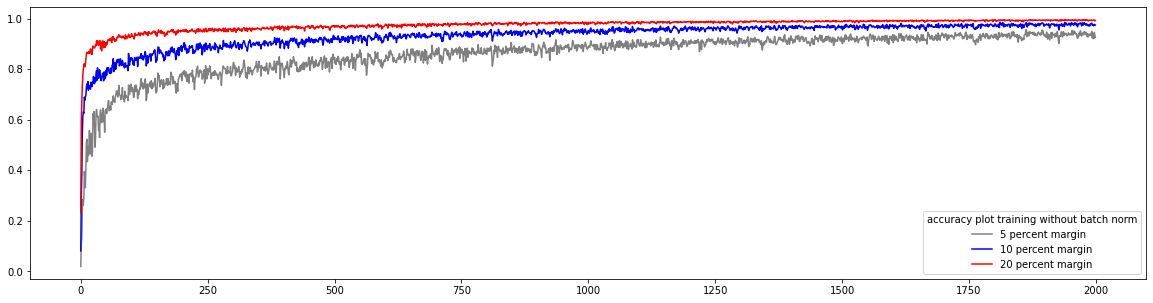

In [10]:
plt.figure(figsize = (20,5))
plt.plot(ta5, color='grey', label='5 percent margin')
plt.plot(ta10, color='blue', label = '10 percent margin')
plt.plot(ta20, color='red', label = '20 percent margin')
plt.legend(title = 'accuracy plot training without batch norm')
plt.show()

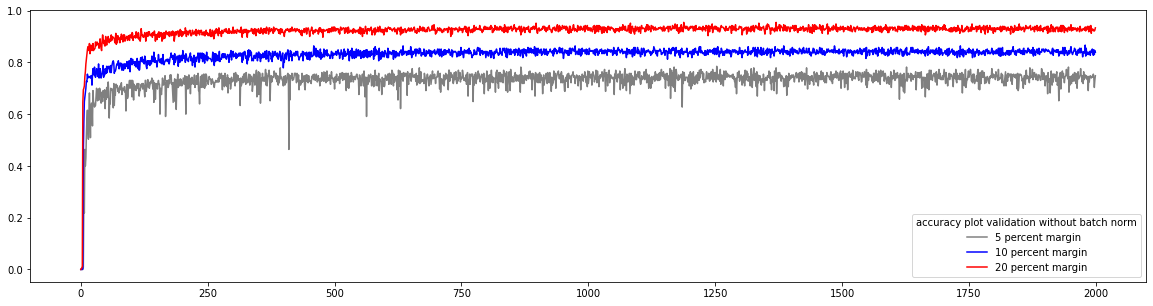

In [11]:
plt.figure(figsize=(20,5))
plt.plot(va5, color='grey', label='5 percent margin')
plt.plot(va10, color='blue', label = '10 percent margin')
plt.plot(va20, color='red', label = '20 percent margin')
plt.legend(title = 'accuracy plot validation without batch norm')
plt.show()

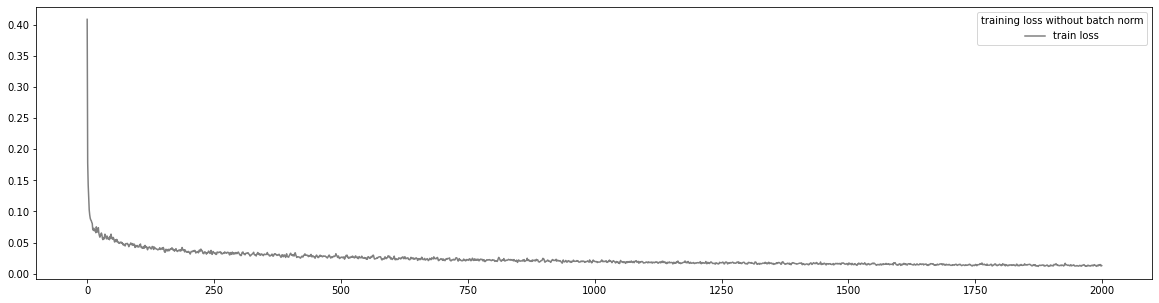

In [12]:
plt.figure(figsize=(20,5))
plt.plot(train_loss, color='grey', label='train loss')
plt.legend(title = 'training loss without batch norm')
plt.show()

In [13]:
max(va5)

0.7848484848484848

In [14]:
max(ta5)

0.956027293404094